# 11.2 Exercise: Survival Analysis - Rahul Rajeev 2/25/2023

**13.1 Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [76]:
# cleaning data
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [77]:
# respondents 
CleanData(resp6)
married6 = resp6[resp6.evrmarry == 1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry == 1]

In [94]:
# estimating survival function
def estimatesurvival(resp):
    divorced = resp[resp.notdivorced == 0].duration.dropna()
    notdivorced = resp[resp.notdivorced == 1].durationsofar.dropna()
    # using hazard function created earlier in the lesson, passing in completed and ongoing as divorced and not divorced
    divorce_hf = survival.EstimateHazardFunction(divorced, notdivorced)
    # using the make survival function from earlier, the complement of the cdf
    divorce_sf = divorce_hf.MakeSurvival()
    return divorce_hf, divorce_sf

# grouping the respondents by decade and plotting survival curves
def survivalbydecade(groups, **options):
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = estimatesurvival(group)
        thinkplot.Plot(sf, **options)

In [97]:
# plotting the resampled sets per decade

def resampleddivorcebydecade(resps):
    for i in range(25):
        resamples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        newsample = pd.concat(resamples, ignore_index=True)
        groups = newsample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)
        survivalbydecade(groups, alpha=0.1)
    thinkplot.Config(xlabel="Years (yr)", ylabel="Undivorced (%)", axis=[0, 30, 0, 1])

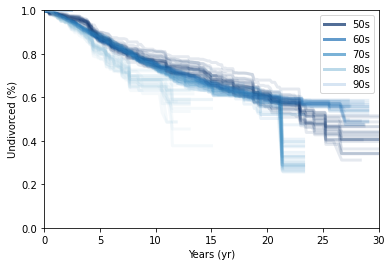

In [98]:
# checking results

resampleddivorcebydecade([married6, married7])

**Thoughts:** Each resample seems to be quite accurate, but the decades of the 60s and the 90s appear to branch off earlier, meaning that those cohorts of people seem to get divorced a lot earlier than the other decades, which seem to follow the curve well past 30 years.